Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Smallest width: 384: Smallest height: 127



100%|██████████| 2862/2862 [00:15<00:00, 178.92it/s]

100%|██████████| 1411/1411 [00:08<00:00, 169.18it/s]


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 125, 125, 16)      208       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 62, 62, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 62, 62, 32)        2080      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 31, 31, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 31, 31, 64)        8256      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 15, 15, 64)       

<ipython-input-7-bbeb93034786>:159: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['virale_pneumonia', 'bacteriele_pneumonia'])


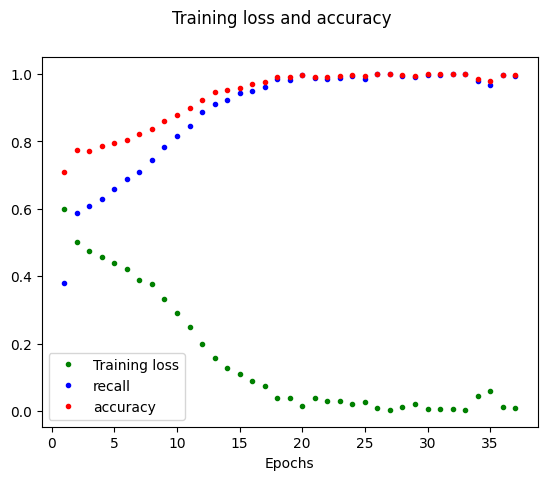

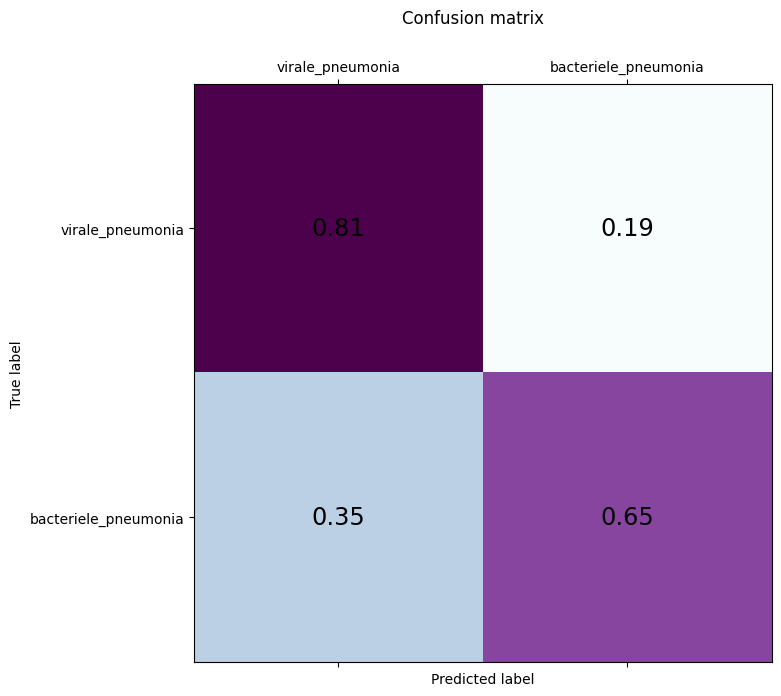

The accuracy is: 75.3%
The true positive rate is: 64.6%


In [ ]:
# After analyzing the images with the first algorithm and differentiating between
# lungs infected with pneumonia and healthy lungs, this second algorithm scans
# the categorized infected images for a second analysis to distinguish between
# bacterial pneumonia and viral pneumonia.

import numpy as np
from sklearn.model_selection import train_test_split
import os
from keras.preprocessing import image
from tensorflow.python.keras.callbacks import EarlyStopping
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
#import shap

def collect_images(path,target):
    images_list = []
    target_list = []
    target = target
    for r, d, f in os.walk(path):
        for file in f:
            if ('.jpeg' in file):
                images_list.append(os.path.join(r, file))
                target_list.append(target)

    features =np.transpose([np.array(images_list)])
    labels = np.transpose([np.array(target_list)])

    return features,labels


def convert_img(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(125, 125))
    # convert PIL.Image.Image type to 3D tensor with shape (40, 40, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 40, 40, 3) and return 4D tensor
    exp_array = np.expand_dims(x, axis=0)
    return exp_array.astype('float32')/255

def paths_to_images(images):
    list_of_images = [convert_img(img_path) for img_path in tqdm(images)]
    return np.vstack(list_of_images)


def find_smallest_dimension():
    #high unrealistic initial values
    width = 10000
    height = 10000
    for i in range(len(features)):
        path = features[i,0]
        img = image.load_img(path)
        tmp_width, tmp_height = img.size

        if tmp_width < width:
            width = tmp_width
        if tmp_height < height:
            height = tmp_height

    print("Smallest width: %d: Smallest height: %d" %(width,height))

# Montar Google Drive (opcional, si tus datos están en Google Drive)
from google.colab import drive
drive.mount('/content/drive')

# Ruta a la carpeta principal del dataset
#base_dir = '/content/drive/My Drive/data2'  # Asegúrate de cambiar esto a la ruta correcta

normal_path = "/content/drive/My Drive/data2/bacteria"
ill_path = "/content/drive/My Drive/data2/virus"

normal_X,  normal_Y= collect_images(normal_path,target=0)
ill_X,ill_Y = collect_images(ill_path,target=1)

features = np.concatenate((normal_X,ill_X),axis=0)
labels = np.concatenate((normal_Y,ill_Y),axis=0)


find_smallest_dimension()

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)

train_tensor = paths_to_images(X_train.flatten())
test_tensor = paths_to_images(X_test.flatten())

model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16,kernel_size=2,strides=1,padding='same', activation='relu', input_shape=train_tensor.shape[1:]),
        tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2),
        tf.keras.layers.Conv2D(32,kernel_size=2,strides=1,padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2),
        tf.keras.layers.Conv2D(64,kernel_size=2,strides=1,padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(500, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')])

model.summary()


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall(name='recall'), 'accuracy'])

early_stopping_monitor = EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

history = model.fit(train_tensor,
                    y_train.flatten(),
                    callbacks=[early_stopping_monitor],
                    epochs=100,
                    verbose=2)


eval_results = model.evaluate(test_tensor, y_test.flatten(), verbose=2)

loss = history.history['loss']
rec = history.history['recall']
acc = history.history['accuracy']

epochs = range(1, len(loss) + 1)

fig_SI = plt.figure()

ax1_SI = fig_SI.add_subplot(111)

ax1_SI.plot(epochs, loss, 'g.', label='Training loss')
ax1_SI.plot(epochs, rec, 'b.', label='recall')
ax1_SI.plot(epochs, acc, 'r.', label='accuracy')

fig_SI.suptitle('Training loss and accuracy')
ax1_SI.set_xlabel('Epochs')
ax1_SI.legend()
fig_SI.show()

def visualize_confusion(conf_matrix, name):
    # normalize values
    normalized_conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

    conf_figure, ax = plt.subplots(figsize=(7.5, 7.5))

    ax.matshow(normalized_conf_matrix, cmap=plt.cm.BuPu)
    for i in range(normalized_conf_matrix.shape[0]):
        for j in range(normalized_conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=round(normalized_conf_matrix[i, j], 2), va='center', ha='center', size='xx-large')

    conf_figure.suptitle('Confusion matrix')
    tick_marks = np.arange(len(conf_matrix))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(['virale_pneumonia', 'bacteriele_pneumonia'])
    ax.set_yticklabels(['virale_pneumonia', 'bacteriele_pneumonia'])
    ax.set_yticks(tick_marks)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

    filename = name + '_Confusion_matrix'

    conf_figure.savefig(filename, bbox_inches='tight')
    plt.show()

    return normalized_conf_matrix[1, 1]


prediction = model.predict(test_tensor)
rounded_prediction = tf.math.round(prediction)
# create a confusion matrix
conf_matrix = confusion_matrix(y_true=y_test.flatten(), y_pred=rounded_prediction)
keras_name = 'pneumonia'
tpr = visualize_confusion(conf_matrix,keras_name)

print('The accuracy is: ' +'{:.1%}'.format(eval_results[2]))
print('The true positive rate is: ' +'{:.1%}'.format(tpr))

In [ ]:
# guardar modelo

import os

currentDirectory = os.getcwd()  # Obtiene el directorio actual
model_name = 'model_02'
model_path = model_name + ".h5"
model.save(model_path)
model_path_for_tiny = os.path.join(currentDirectory, model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
